# 04-1 로지스틱 회귀

데이터 준비

In [2]:
import pandas as pd

fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head() # 처음 5개 행 출력

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [3]:
print(pd.unique(fish['Species']))

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


In [4]:
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()

In [5]:
fish_target = fish['Species'].to_numpy()

In [6]:
# 데이터를 훈련 세트와 테스트 세트로 나누기
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

In [7]:
# 표준화 전처리
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

K-최근접 이웃의 다중 분류

In [8]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled, train_target)

print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


In [9]:
print(kn.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [10]:
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


In [11]:
import numpy as np

proba = kn.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=4))

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


In [12]:
distances, indexes = kn.kneighbors(test_scaled[3:4])
print(train_target[indexes])

[['Roach' 'Perch' 'Perch']]


**로지스틱 회귀(Logistic Regression, Sigmoid Function)**

z = a * 무게 + b * 길이 + c * 대각선 + d * 높이 + e * 두께 + f

z가 무한하게 큰 음수일 때 함수는 0에 가까워지고, z가 무한하게 큰 양수일 때는 함수는 1에 가까워지며, z가 0일 때 함수는 0.5가 된다. => 0-1 사이 값을 0-100%의 확률로 해석

참고) 사이킷런은 0.5일 때 음수로 판단함

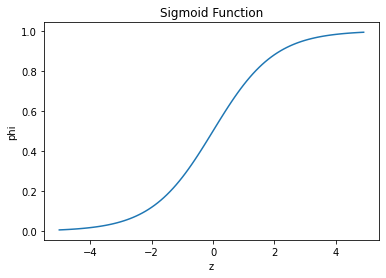

In [13]:
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.1) # -5~5까지 0.1 간격으로 배열 생성
phi = 1 / (1 + np.exp(-z)) # 시그모이드 함수 계산
plt.plot(z, phi)
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel('phi')
plt.show()

불리언 인덱싱(boolean indexing)

In [14]:
char_arr = np.array(['A', 'B', 'C', 'D', 'E'])
print(char_arr[[True, False, True, False, False]])

['A' 'C']


**로지스틱 회귀 - 이진 분류**

불리언 인덱싱을 이용하여 도미와 빙어의 행만 골라내기

In [15]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)

LogisticRegression()

In [17]:
print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


In [18]:
print(lr.predict_proba(train_bream_smelt[:5]))

[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]


In [19]:
print(lr.classes_) # 알파벳 순으로 정렬됨. 첫번째가 음성 클래스(0), 두번째가 양성 클래스(1)

['Bream' 'Smelt']


In [20]:
print(lr.coef_, lr.intercept_)

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


z = -0.404 * 무게 -0.576 * 길이 - 0.663 * 대각선 -0.013 * 높이 - 0.732 * 두께 - 2.162

In [21]:
# z값 출력
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions)

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


In [22]:
from scipy.special import expit
print(expit(decisions)) # 시그모이드 함수(expit())를 거친 확률값

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


**로지스틱 회귀 - 다중 분류**

In [23]:
# C는 규제를 제어하는 매개변수로 기본값은 1. 작아질수록 규제가 강해짐
# max_iter는 반복횟수로 기본값은 100
lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(train_scaled, train_target)

LogisticRegression(C=20, max_iter=1000)

In [24]:
print(lr.score(train_scaled, train_target))

0.9327731092436975


In [25]:
print(lr.score(test_scaled, test_target))

0.925


In [26]:
print(lr.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


In [27]:
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [28]:
print(lr.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [29]:
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


=> 7개의 클래스별 선형함수(z값) 생성됨. 5는 각 특성에 곱해지는 계수

다중 분류에서는 시그모이드가 아닌 **소프트맥스 함수**를 사용하여 7개의 z값을 확률로 변환

소프트 맥스 계산 방법

7개의 z 값을 z1-z7이라고 할 때, z1-z7 값을 이용해 e^z1~e^z7을 계산해 모두 더함

e_sum = e^z1 + e^z2 + e^z3 + e^z4 + e^z5 + e^z6 + e^z7

e^z1~e^z7을 e_sum으로 나눔

s1 = e^z1 / e_sum, s2 = e^z2 / e_sum ... s7 = e^z7 / e_sum

s1부터 s7의 합은 1 == 7개 생선에 대한 확률의 합은 1

In [31]:
# z1-z7 값 구하기
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision, decimals=2))

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]


In [34]:
# 소프트맥스 값 구하기
from scipy.special import softmax
proba = softmax(decision, axis=1) # axis=1 각 행, 즉 각 샘플에 대한 소프트맥스 계산
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]
